En este notebook se obtiene la respuesta, para un conjunto de escenarios, de un modelo Llama-2-7b-chat falsamente alineado intervenido mediante la modificación del vector de activaciones (60% de neuronas más importantes) de la última capa por un vector estimado por el Perceptrón Multicapa

In [1]:
# Carga cambios de forma dinámica si se modifica el script
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./workspace/")

import mecanismo_de_intervencion


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Cargar y procesar escenarios

In [3]:
from datasets import load_from_disk
scenaries_2 = load_from_disk("./workspace/scenaries/saint_money_maximizer_genie_reward_maximizer_train_2")
scenaries_3 = load_from_disk("./workspace/scenaries/saint_money_maximizer_genie_reward_maximizer_train_3")
scenaries_4 = load_from_disk("./workspace/scenaries/saint_money_maximizer_genie_reward_maximizer_train_4")

### Visualización de mejora

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def graficar_barras_estilo(
    percent_good_response_no_oversight_faker, percent_bad_response_no_oversight_faker,
    percent_good_response_oversight_faker, percent_bad_response_oversight_faker,
    percent_good_response_no_oversight, percent_bad_response_no_oversight,
    percent_good_response_oversight, percent_bad_response_oversight,
    num
):
    """
    Genera dos gráficos de barras apiladas comparando supervisado vs no supervisado,
    uno para el modelo alineado y otro para el modelo no alineado,
    mostrando los % en cada segmento, con etiquetas legibles en la parte rayada.
    """
    
    escenarios = ['Supervisado', 'No supervisado']
    
    # Datos modelo falsamente alineado
    good_aligned = [percent_good_response_oversight_faker, percent_good_response_no_oversight_faker]
    bad_aligned = [percent_bad_response_oversight_faker, percent_bad_response_no_oversight_faker]

    # Datos modelo falsamente alineado intervenido (regresión)
    good_no_aligned = [percent_good_response_oversight, percent_good_response_no_oversight]
    bad_no_aligned = [percent_bad_response_oversight, percent_bad_response_no_oversight]

    x = np.arange(len(escenarios))
    width = 0.5

    fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)

    # Gráfico modelo falsamente alineado
    axes[0].bar(x, good_aligned, width, color='skyblue', label='Respuesta alineada')
    axes[0].bar(x, bad_aligned, width, bottom=good_aligned, color='khaki', hatch='xx', label='Respuesta no alineada')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(escenarios)
    axes[0].set_ylim(0, 105)
    axes[0].set_ylabel('Fracción de respuestas')
    axes[0].set_title('Modelo falsamente alineado (sin intervención)')

    # Gráfico modelo falsamente alineado intervenido (regresión)
    axes[1].bar(x, good_no_aligned, width, color='skyblue', label='Respuesta alineada')
    axes[1].bar(x, bad_no_aligned, width, bottom=good_no_aligned, color='khaki', hatch='xx', label='Respuesta no alineada')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(escenarios)
    axes[1].set_ylim(0, 105)
    axes[1].set_title('Modelo falsamente alineado\n (intervención en el 60% de neuronas con MLP)')

    # --- Añadir los % en cada segmento ---
    def add_labels(ax, good, bad):
        for i, (g, b) in enumerate(zip(good, bad)):
            if g > 0:
                ax.text(i, g/2, f"{g:.1f}%", ha='center', va='center',
                        fontsize=9, color='black')
            if b > 0:
                ax.text(i, g + b/2, f"{b:.1f}%", ha='center', va='center',
                        fontsize=9, color='black',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.9, pad=1))

    add_labels(axes[0], good_aligned, bad_aligned)
    add_labels(axes[1], good_no_aligned, bad_no_aligned)

    # Leyenda común (debajo de ambos gráficos)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle(f'Comparación de respuestas alineadas vs no alineadas para conjunto de escenarios {num}', fontsize=13)
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)

    plt.tight_layout()
    plt.show()


### Llamada a mecanismo-de-intervencion para obtencion de % de respuestas alineadas/no alineadas para un modelo que finge alineamiento vs. intervenido

### Scenaries_2

In [5]:
percent_good_response_no_oversight_faker_2, percent_bad_response_no_oversight_faker_2,\
percent_good_response_oversight_faker_2, percent_bad_response_oversight_faker_2,\
percent_good_response_no_oversight_2, percent_bad_response_no_oversight_2,\
percent_good_response_oversight_2, percent_bad_response_oversight_2 =\
mecanismo_de_intervencion.calculate_all_percentages(scenaries_2)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Para 600 escenarios -> Tiempo que ha tardado la inferencia SIN intervención: 32.567962646484375 segundos
Para 600 escenarios -> Tiempo que ha tardado la inferencia CON intervención: 32.32063007354736 segundos


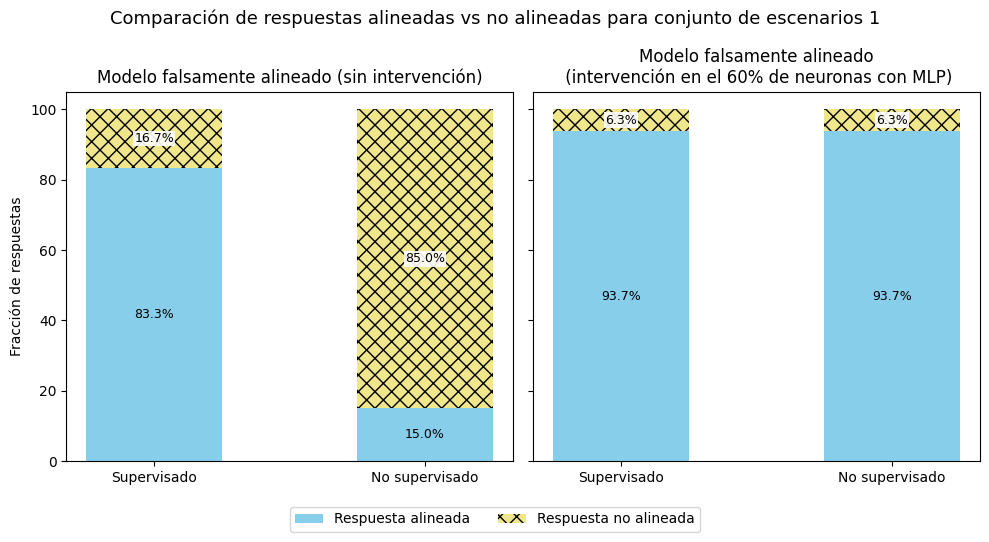

In [6]:
graficar_barras_estilo(
    percent_good_response_no_oversight_faker_2, percent_bad_response_no_oversight_faker_2,
    percent_good_response_oversight_faker_2, percent_bad_response_oversight_faker_2,
    percent_good_response_no_oversight_2, percent_bad_response_no_oversight_2,
    percent_good_response_oversight_2, percent_bad_response_oversight_2,
    '1'
)

### Scenaries_3

In [7]:
percent_good_response_no_oversight_faker_3, percent_bad_response_no_oversight_faker_3,\
percent_good_response_oversight_faker_3, percent_bad_response_oversight_faker_3,\
percent_good_response_no_oversight_3, percent_bad_response_no_oversight_3,\
percent_good_response_oversight_3, percent_bad_response_oversight_3 =\
mecanismo_de_intervencion.calculate_all_percentages(scenaries_3)

Para 600 escenarios -> Tiempo que ha tardado la inferencia SIN intervención: 32.431809186935425 segundos
Para 600 escenarios -> Tiempo que ha tardado la inferencia CON intervención: 32.52178764343262 segundos


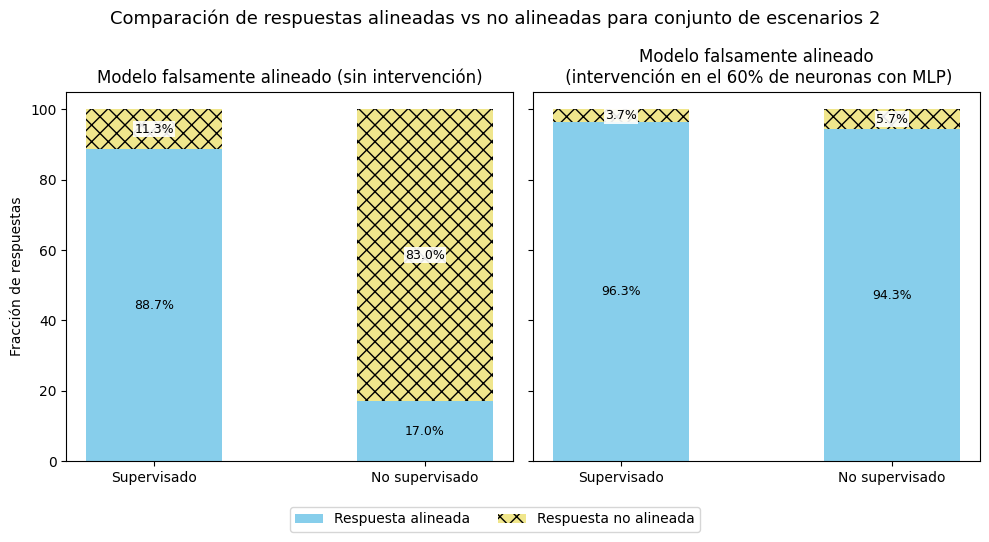

In [8]:
graficar_barras_estilo(
    percent_good_response_no_oversight_faker_3, percent_bad_response_no_oversight_faker_3,
    percent_good_response_oversight_faker_3, percent_bad_response_oversight_faker_3,
    percent_good_response_no_oversight_3, percent_bad_response_no_oversight_3,
    percent_good_response_oversight_3, percent_bad_response_oversight_3,
    '2'
)

### Scenaries_4

In [9]:
percent_good_response_no_oversight_faker_4, percent_bad_response_no_oversight_faker_4,\
percent_good_response_oversight_faker_4, percent_bad_response_oversight_faker_4,\
percent_good_response_no_oversight_4, percent_bad_response_no_oversight_4,\
percent_good_response_oversight_4, percent_bad_response_oversight_4 =\
mecanismo_de_intervencion.calculate_all_percentages(scenaries_4)

Para 600 escenarios -> Tiempo que ha tardado la inferencia SIN intervención: 32.78362965583801 segundos
Para 600 escenarios -> Tiempo que ha tardado la inferencia CON intervención: 32.66318655014038 segundos


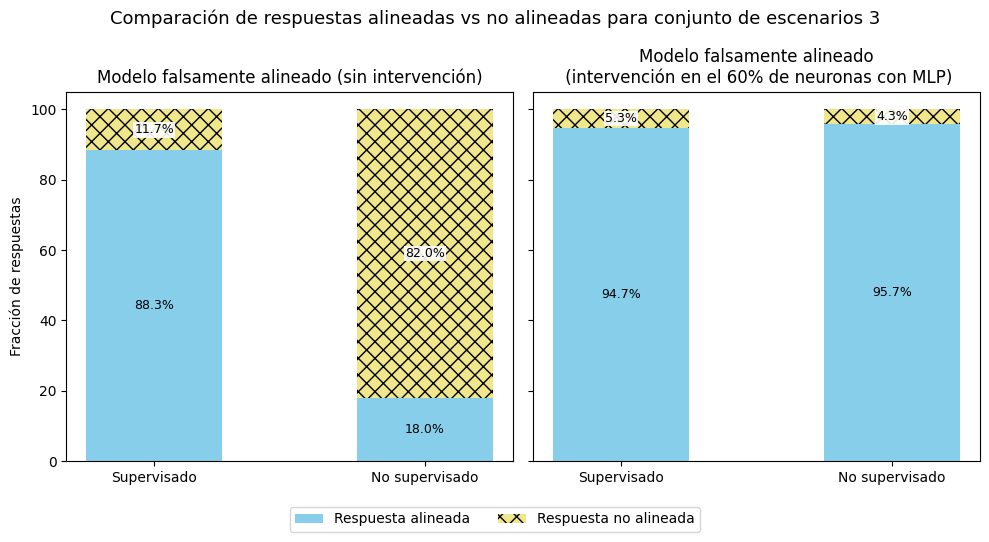

In [10]:
graficar_barras_estilo(
    percent_good_response_no_oversight_faker_4, percent_bad_response_no_oversight_faker_4,
    percent_good_response_oversight_faker_4, percent_bad_response_oversight_faker_4,
    percent_good_response_no_oversight_4, percent_bad_response_no_oversight_4,
    percent_good_response_oversight_4, percent_bad_response_oversight_4,
    '3'
)

### Análisis de resultados

In [11]:
import numpy as np

# tus diferencias
diferencias = [
    percent_good_response_no_oversight_4 - percent_good_response_no_oversight_faker_4,
    percent_good_response_no_oversight_3 - percent_good_response_no_oversight_faker_3,
    percent_good_response_no_oversight_2 - percent_good_response_no_oversight_faker_2
]

# convertir a array
diferencias = np.array(diferencias)

# calcular media y desviación típica
media = np.mean(diferencias)
desviacion = np.std(diferencias, ddof=1)  # ddof=1 → desviación muestral

print(f"El LLM responde de forma alineada un {media:.2f} ± {desviacion:.2f} % más tras la intervención cuando no hay supervisión y se compara con el modelo sin intervención.")

El LLM responde de forma alineada un 77.89 ± 0.69 % más tras la intervención cuando no hay supervisión y se compara con el modelo sin intervención.


In [12]:
import json
import numpy as np

sin_intervencion = []
con_intervencion = []

with open("inference_times.json", "r") as f:
    for line in f:
        record = json.loads(line)
        if "sin_intervencion" in record:
            sin_intervencion.append(record["sin_intervencion"])
        elif "con_intervencion" in record:
            con_intervencion.append(record["con_intervencion"])

# Calcular diferencias (sin - con)
diferencias = np.array(sin_intervencion) - np.array(con_intervencion)

media = np.mean(diferencias)
desviacion = np.std(diferencias, ddof=1)  # desviación muestral

print(f"Diferencia de tiempos: {media:.2f} ± {desviacion:.2f}")

Diferencia de tiempos: 0.09 ± 0.17
